In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import mliv.dgps_mediated as dgps
from mliv.ensemble import EnsembleIV, EnsembleIVStar
from mliv.rkhs import ApproxRKHSIVCV
from mliv.shape import LipschitzShapeIV, ShapeIV
from mliv.linear import OptimisticHedgeVsOptimisticHedge, StochasticOptimisticHedgeVsOptimisticHedge
from mliv.linear import L2OptimisticHedgeVsOGD, L2ProxGradient
from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AGMM, KernelLayerMMDGMM, CentroidMMDGMM, KernelLossAGMM, MMDGMM
from mliv.tsls import tsls, regtsls

p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook

# For any method that use a projection of z into features g(z)
g_features = 100

# The kernel function
kernel_fn = gaussian
# kernel_fn = inverse_multiquadric

# Training params
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-4
adversary_norm_reg = 1e-3
n_epochs = 300
bs = 100
sigma = 2.0 / g_features
n_centers = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None


In [2]:
from dml_mediated import DML_mediated

In [3]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)
tauinv_fn = dgps.get_tauinv_fn(fn_number)
W, Z, X, M, D, Y, tau_fn = dgps.get_data(2000, tau_fn)

V = np.random.rand(Y.shape[0])
V = V.reshape(-1, 1)

print(np.column_stack((W,X,Z)).shape)
ind = np.where(D==0)[0]
W0 = W[ind]
X0 = X[ind,:]
W0_test = np.zeros((1000, 1+X.shape[1]))
W0_test += np.median(np.column_stack((X0,W0)), axis=0, keepdims=True)
W0_test[:, 2] = np.linspace(np.percentile(
            W0[:, 0], 5), np.percentile(W0[:, 0], 95), 1000)

# True parameters
b_yd = 2.0; b_ym = 1.0; b_yx = np.array([[-1.0],[-1.0]]); b_yu = -1.0; b_yw = 2.0; b_y0 = 2.0
b_wx = np.array([[0.2],[0.2]]); b_wu = -0.6; b_w0 = 0.3
b_md = -0.3; b_mx = np.array([[-0.5],[-0.5]]); b_mu = 0.4; b_m0 = 0.0
    
gamma_1w = (b_yw*b_wu + b_yu)/b_wu
gamma_1x = b_yw*b_wx + b_yx - gamma_1w*b_wx
gamma_1m = b_ym
gamma_10 = b_y0 + b_yd + b_yw*b_w0 - gamma_1w*b_w0

gamma_0w = (gamma_1m*b_mu + gamma_1w*b_wu)/b_wu
gamma_0x = gamma_1m*b_mx + gamma_1w*b_wx + gamma_1x - gamma_0w*b_wx
gamma_00 = gamma_10 + gamma_1m*b_m0 + gamma_1w*b_w0 - gamma_0w*b_w0

    # True nuisance function
expected_te = gamma_00 + tauinv_fn(W0_test)@np.row_stack((gamma_0x, gamma_0w))


(2000, 4)


In [4]:
rkhs_model = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=100,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)

def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary_g(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, g_features), nn.ReLU())


agmm_1 = AGMM(_get_learner(4),_get_adversary(4))
agmm_2 = AGMM(_get_learner(3),_get_adversary(3))

In [5]:
dml_rkhs = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3)

dml_agmm = DML_mediated(Y, D, M, W, Z, X,
                        model1 = agmm_1,
                        model2 = agmm_2,
                        modelq1 = agmm_2,
                        modelq2 = agmm_1,
                        n_folds=5, n_rep=1,
                        CHIM = False,
                        nn_1 = True,
                        nn_2 = True,
                        nn_q1 = True,
                        nn_q2 = True,
                        fitargs1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4, 'adversary_norm_reg' : 1e-3},
                        fitargs2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        opts = {'lin_degree': 1, 'burnin': 200})

dml_2sls = DML_mediated(Y, D, M, W, Z, X,
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                n_folds=10, n_rep=3)

dml_2sls_chim = DML_mediated(Y, D, M, W, Z, X,
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                        CHIM=True,
                n_folds=10, n_rep=3)


dml_rfiv = DML_mediated(Y, D, M, W, Z, X,
                        model1 = EnsembleIV(n_iter=200, max_abs_value=2),
                        model2 = EnsembleIV(n_iter=200, max_abs_value=2),
                        modelq1 = EnsembleIV(n_iter=200, max_abs_value=2),
                        modelq2 = EnsembleIV(n_iter=200, max_abs_value=2),
                n_folds=5, n_rep=1)    


In [6]:
dml_rkhs_or = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='OR')

dml_rkhs_ipw = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='IPW')

dml_rkhs_hybrid = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='hybrid')


In [7]:
print(dml_rkhs.dml())

Rep: 1


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Rep: 2


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Rep: 3


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

(4.0298329756591285, 29.25228833780929, array([3.79279768, 4.26686827]))


In [8]:
print(dml_rkhs_or.dml())

Rep: 1


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Rep: 2


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Rep: 3


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

(4.022787495428855, 12.11270644927077, array([3.87025805, 4.17531694]))


In [9]:
print(dml_rkhs_ipw.dml())

Rep: 1


100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


Rep: 2


100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Rep: 3


100%|██████████| 5/5 [00:00<00:00,  5.94it/s]

(3.955186439844408, 52.45312666433774, array([3.63777777, 4.27259511]))


In [10]:
print(dml_rkhs_hybrid.dml())

Rep: 1


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Rep: 2


100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


Rep: 3


100%|██████████| 5/5 [00:01<00:00,  5.00it/s]

(4.0018029405902915, 56.70245582416896, array([3.67178768, 4.3318182 ]))


In [11]:
print(dml_2sls.dml())
print(dml_2sls_chim.dml())

Rep: 1


100%|██████████| 10/10 [00:00<00:00, 67.04it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 66.52it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 71.17it/s]


(4.047376120067359, 27.141995035226127, array([3.81905085, 4.27570139]))
Rep: 1


100%|██████████| 10/10 [00:00<00:00, 40.71it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 42.91it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 41.18it/s]

(4.047361082250958, 27.14060258932391, array([3.81904167, 4.27568049]))


In [8]:
_ , gamma_0 = dml_2sls._nnpivfit_outcome(Y=Y, D=D, M=M, W=W, X=X, Z=Z)
gamma0_hat = gamma_0.predict(W0_test)


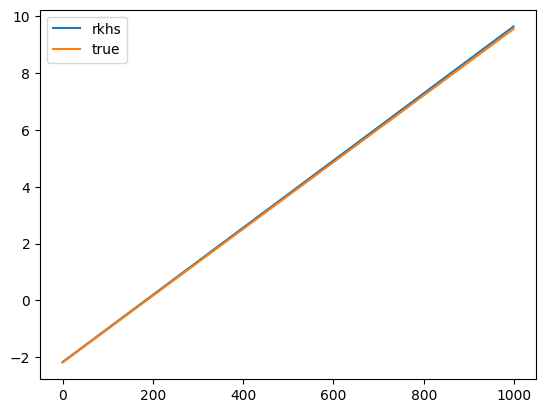

In [9]:

plt.show()
plt.plot(gamma0_hat)
plt.plot(expected_te)
plt.legend(['rkhs', 'true'])

In [14]:

print(np.mean(gamma_0.predict(np.column_stack((X, W)))))
#In principle this should be the same as the 'OR' estimator


4.040254423457863


In [15]:
dml_2sls.dml()

Rep: 1


100%|██████████| 10/10 [00:00<00:00, 66.33it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 73.45it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 79.90it/s]


(4.047376120067359, 27.141995035226127, array([3.81905085, 4.27570139]))

In [16]:
dml_reg2sls = DML_mediated(Y, D, M, W, Z, X,
                           estimator='MR',
                        model1 = regtsls(),
                        model2 = regtsls(),
                        modelq1 = regtsls(),
                        modelq2 = regtsls(),
                n_folds=10, n_rep=3)     


dml_reg2sls.dml()

Rep: 1


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Rep: 2


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Rep: 3


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


(4.046824973908222, 26.644646590513187, array([3.82060129, 4.27304866]))

In [17]:
percentiles = np.arange(5, 100, 5)
v_values = np.percentile(V, percentiles)

dml_2sls = DML_mediated(Y, D, M, W, Z, X, V=V,
                        v_values=v_values,
                        loc_kernel = 'gau',
                        bw_loc = 'scott',
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                n_folds=10, n_rep=3)

theta, vart, ci = dml_2sls.dml()

print(theta)
print(np.mean(theta, axis=0))
print(vart)
print(ci)


Rep: 1


100%|██████████| 10/10 [00:00<00:00, 20.69it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 20.99it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 21.37it/s]

[3.59570586 3.70753439 3.9430394  4.11602209 4.12782642 4.09841558
 4.14478774 4.20512329 4.20992929 4.13053864 4.01019152 3.9380058
 3.94872085 4.00686156 4.1107328  4.19255661 4.19815624 4.18594161
 4.19915086]
4.056275818520639
[213.34519207 174.21294411 166.7217622  180.47702628 171.3785261
 151.04551267 152.1040084  159.49146151 159.52543026 153.66435424
 157.92823485 174.67156715 183.86548909 178.06517848 171.85683124
 182.07318883 186.40432817 194.9256151  240.99324117]
[[2.95556652 4.23584521]
 [3.12907443 4.28599435]
 [3.37715302 4.50892577]
 [3.52725428 4.7047899 ]
 [3.55409148 4.70156135]
 [3.55978996 4.6370412 ]
 [3.60427813 4.68529735]
 [3.65164344 4.75860314]
 [3.65639051 4.76346808]
 [3.58726372 4.67381357]
 [3.45943077 4.56095227]
 [3.35878493 4.51722667]
 [3.35445167 4.54299002]
 [3.42204105 4.59168207]
 [3.53619779 4.6852678 ]
 [3.60119096 4.78392226]
 [3.59979825 4.79651422]
 [3.57405979 4.79782343]
 [3.51879595 4.87950577]]
